# Whisky Reviews - Basic Exploratory Data Analysis

Vamos a trabajar en este proyecto sobre una lista de mas de 200 marcas de whisky. Intentaremos crear un algoritmo para poder predecir en funcion de los datos que tenemos el rating (valoracion) del whisky y ver si se aproxima a la valoracion real.

Solo disponemos de un archico CSV con lo cual trabajaremos con el archico original y tras hacer todas las transformaciones lo dividiremos en datos para training y para test.

Context

Dataset was scraped from Whisky Advocate. 

https://www.kaggle.com/koki25ando/22000-scotch-whisky-reviews

Content

name: Name of whisky bottle
category: Whisky category
review.point: Point marked by each reviewers
price: Price of each bottle
currency: Unit of price
description: Descriptions of reviews

Original database is from Whisky Advocate.

Inspiration

Can you find characteristics of each category of whisky?


In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm
import seaborn as sns
import re
import itertools
import warnings
import string
from collections import Counter
from itertools import chain
import time

import seaborn as sns
%matplotlib inline
%matplotlib notebook
%config InlineBackend.figure_format='retina'

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier

warnings.filterwarnings('ignore')

In [3]:
# Análisis de datos y renombramos algunas columnas

df = pd.read_csv('./scotch_review.csv')

df.rename(columns = {'Unnamed: 0': 'Index'}, inplace = True)
df.rename(columns = {'review.point': 'rating'}, inplace = True)


Veamos que tipo de datos tenemos en cada columna.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2247 entries, 0 to 2246
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Index        2247 non-null   int64 
 1   name         2247 non-null   object
 2   category     2247 non-null   object
 3   rating       2247 non-null   int64 
 4   price        2247 non-null   object
 5   currency     2247 non-null   object
 6   description  2247 non-null   object
dtypes: int64(2), object(5)
memory usage: 123.0+ KB


Tenemos que convertir el precio en valor de tipo float. Pero hay algunos valores que tenemos que corregir:

In [6]:
symbol_idx = pd.to_numeric(df['price'], errors = 'coerce').isnull() 
# errors = 'coerce' nos da NaNs para valores no numericos
df[symbol_idx][['name','price']].head(10)

,name,price
19,"Balvenie 1973 43 year old, 46.6%","$15,000 or $60,000/set"
49,"Bowmore 1966 50 year old, 41.5%","30,000"
95,"Balvenie 1961 55 year old, 41.7%","60,000/set"
100,Brora 34 year old (Diageo Special Releases 201...,"1,700"
102,"Bruichladdich 1984, 43.7%","1,100"
109,"Dalmore 50 year old, 40%","60,000"
140,Port Ellen 37 year old (Diageo Special Release...,"3,500"
147,"The Last Drop 1971, 47.2%","4,000"
191,"Bruichladdich 1985, 48.7%","1,100"
197,"Dalmore 40 year old, 42%","7,500"


In [7]:
#Hacemos 'limpieza' de los datos que tenemos en la columna precio para homogeneizarlos

df['price'].replace('/liter', '', inplace = True, regex = True) 
df['price'].replace('liter', '', inplace = True, regex = True) 
df['price'].replace(',', '', inplace = True, regex = True)
df['price'].replace('/375ml', '', inplace = True, regex = True)
df['price'].replace('/700ml', '', inplace = True, regex = True)
df['price'].replace('/set', '', inplace = True, regex = True)
df['price'].replace('/1.75', '', inplace = True, regex = True)
df.at[[19], 'price'] = 15000   
df['price'] = df['price'].astype('float')

Parece logico pensar que podemos relacionar el precio y la calidad (rating) Creamos una nueva columna 'price_p_points'

In [6]:
df['price_p_points'] = df['price']/df['rating']

In [7]:
# Dividimos los datos 70% para training 30% test

#msk = np.random.rand(len(df)) <= 0.7

#train_df = df[msk]
#test_df = df[~msk]
#df

In [8]:
#train_df['description'][1]

In [9]:
#test_df

Vemos que en la columna "currency" parece haber solo un valor. Comprobamos esto y eliminamos al columna al no aportar informacion adicional.

In [10]:
df['currency'].value_counts()

$    2247
Name: currency, dtype: int64

In [105]:
df.drop('currency', axis = 1, inplace = True)
print(df.columns.values)

['Index' 'name' 'category' 'rating' 'price' 'description' 'age' 'alcohol%'
 'Adjectives Ranking']


Comprobamos si hay valores nulos en precio

In [106]:
df['price'].describe()

count      2247.000000
mean        643.117490
std        4702.631546
min          12.000000
25%          70.000000
50%         110.000000
75%         200.000000
max      157000.000000
Name: price, dtype: float64

In [107]:
#Podemos agrupar los diferentes whiskies por categoria

grouped_df = df.groupby('category')
for name, group in grouped_df:
    print("Category : ", name)
    cnt = 0
    for ind, row in group.iterrows():
        print(row["description"])
        print("\n")
        cnt += 1
        if cnt == 2:
            break
    
    print("\n\n")

Category :  Blended Malt Scotch Whisky
With a name inspired by a 1926 Buster Keaton movie, only 1,698 bottles produced, and the news that one of the two batches is more than 30 years old, the clues were there that this blend was never going to be cheap. It isn't, but it's superb, rich in flavor that screams dusty old oak office, fresh polish, and Sunday church, with spices, oak dried fruits, squiggly raisins, and a surprising melting fruit-and-nut dairy chocolate back story.


Captivating, enticing, and wonderfully charming, this first blended malt from Chivas Regal contains selections of five Speyside malts: Strathisla, Longmorn, Tormore, Allt-a-Bhainne, and Braeval. Red apple, cherry, raspberry fudge, peach and mango fruit salad, dusting of cinnamon, and dry heather sprigs. In essence, it’s rich and satisfying, with dark vanilla, apricot, Bourneville-covered Brazil nuts, and tangerine, smoothed over by caramel and wood spices, maltiness, and gingersnap biscuits. Quite heavenly. Edito

Vamos a dividir los whiskies en categorias y crear un wordcloud en funcion de la descripcion del sabor.

In [108]:
#ahora creamos un wordcloud con las palabras que mejor describen cada categoria.
#primero creamos un numpy array con los valores de la columna descripcion

SMS=df[df.category=="Single Malt Scotch"]['description'].values
BSW=df[df.category=='Blended Scotch Whisky']['description'].values
BMSW=df[df.category=='Blended Malt Scotch Whisky']['description'].values
SGW=df[df.category=='Single Grain Whisky']['description'].values
GSW=df[df.category=='Grain Scotch Whisky']['description'].values

In [109]:
#puede haber valores nulos dentro de la columna descripcion
#los omitimos

SMS = SMS[~pd.isnull(SMS)]
BSW = BSW[~pd.isnull(BSW)]
BMSW = BMSW[~pd.isnull(BMSW)]
SGW = SGW[~pd.isnull(SGW)]
GSW = GSW[~pd.isnull(GSW)]

In [110]:
#hay palabras que no aportan nada acerca de las carateristicas del saber del whisky, las omitimos.

from wordcloud import WordCloud,STOPWORDS

stopwords=set(STOPWORDS)
stopwords=STOPWORDS.add('whisky')
stopwords=STOPWORDS.add('distillery')
stopwords=STOPWORDS.add('whiskies')
stopwords=STOPWORDS.add('bottle')
stopwords=STOPWORDS.add('bottling')
stopwords=STOPWORDS.add('bottles')
stopwords=STOPWORDS.add('year')
stopwords=STOPWORDS.add('flavor')
stopwords=STOPWORDS.add('finish')
stopwords=STOPWORDS.add('one')
stopwords=STOPWORDS.add('old')
stopwords=STOPWORDS.add('note')
stopwords=STOPWORDS.add('year')
stopwords=STOPWORDS.add('palate')
stopwords=STOPWORDS.add('notes')
stopwords=STOPWORDS.add('age')
stopwords=STOPWORDS.add('s')
stopwords=STOPWORDS.add('u')
stopwords=STOPWORDS.add('grain')
stopwords=STOPWORDS.add('oak')
stopwords=STOPWORDS.add('nose')
stopwords=STOPWORDS.add('quite')
stopwords=STOPWORDS.add('blend')
stopwords=STOPWORDS.add('malt')

#determinamos el formato del wordcloud

def show_wordcloud(data,title=None):
    wc=WordCloud(background_color="black", max_words=50,stopwords=STOPWORDS, max_font_size= 40)
    wc.generate(" ".join(data))
    fig=fig = plt.figure(figsize=[9,6], dpi=80)
    plt.axis('off')
    if title:
        fig.suptitle(title,fontsize=16)
        fig.subplots_adjust(top=1)
        plt.imshow(wc.recolor( colormap= 'Pastel2' , random_state=17), alpha=1,interpolation='bilinear')
        plt.show()

<IPython.core.display.Javascript object>


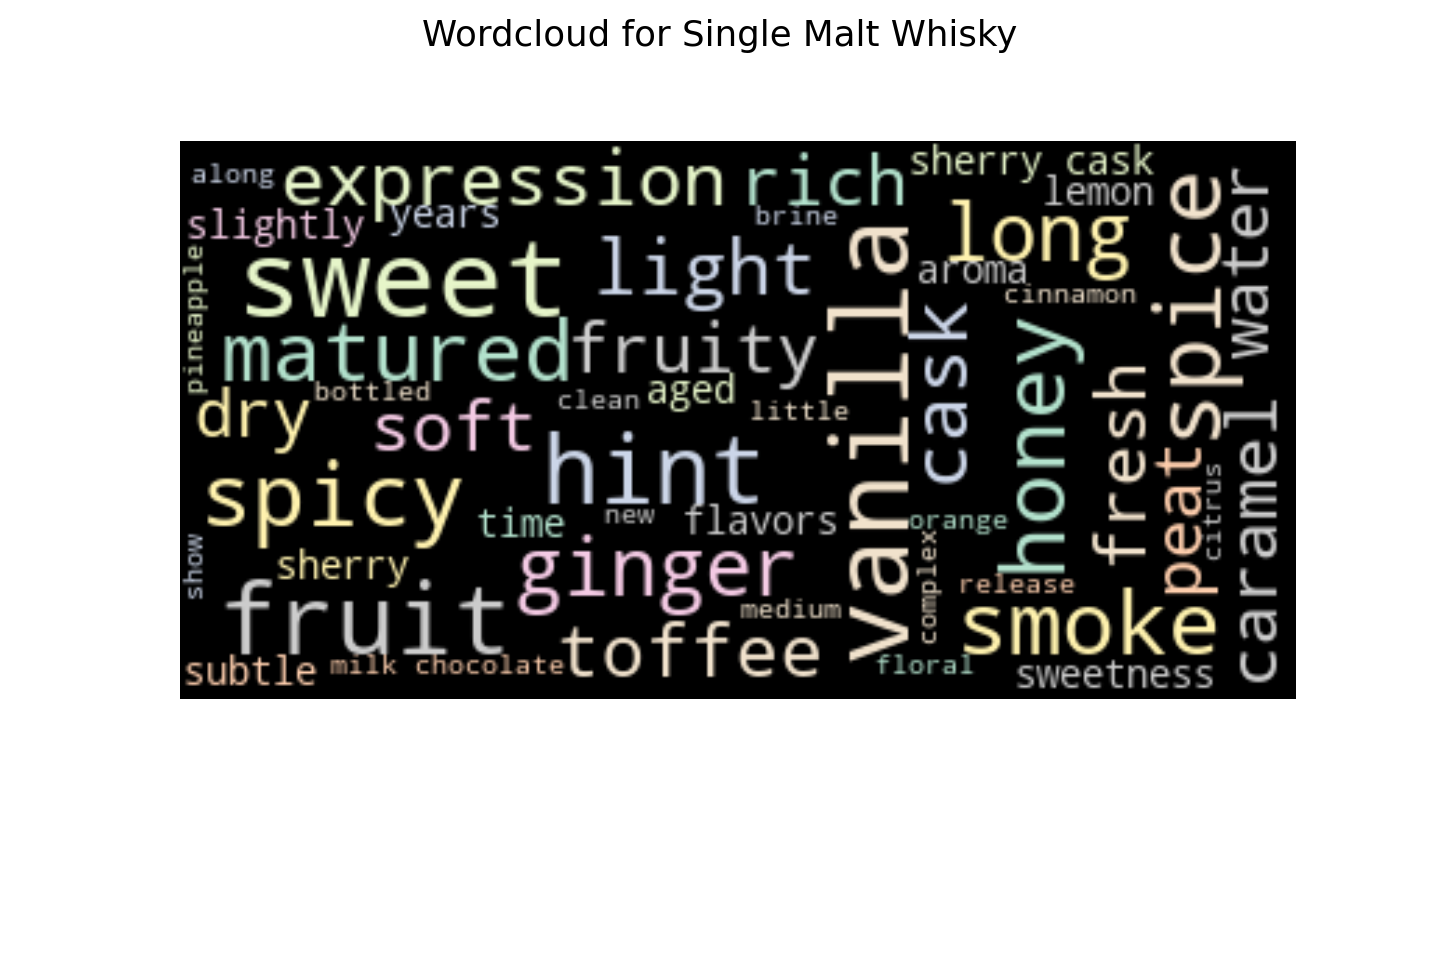

In [111]:
show_wordcloud(SMS,title="Wordcloud for Single Malt Whisky")

<IPython.core.display.Javascript object>


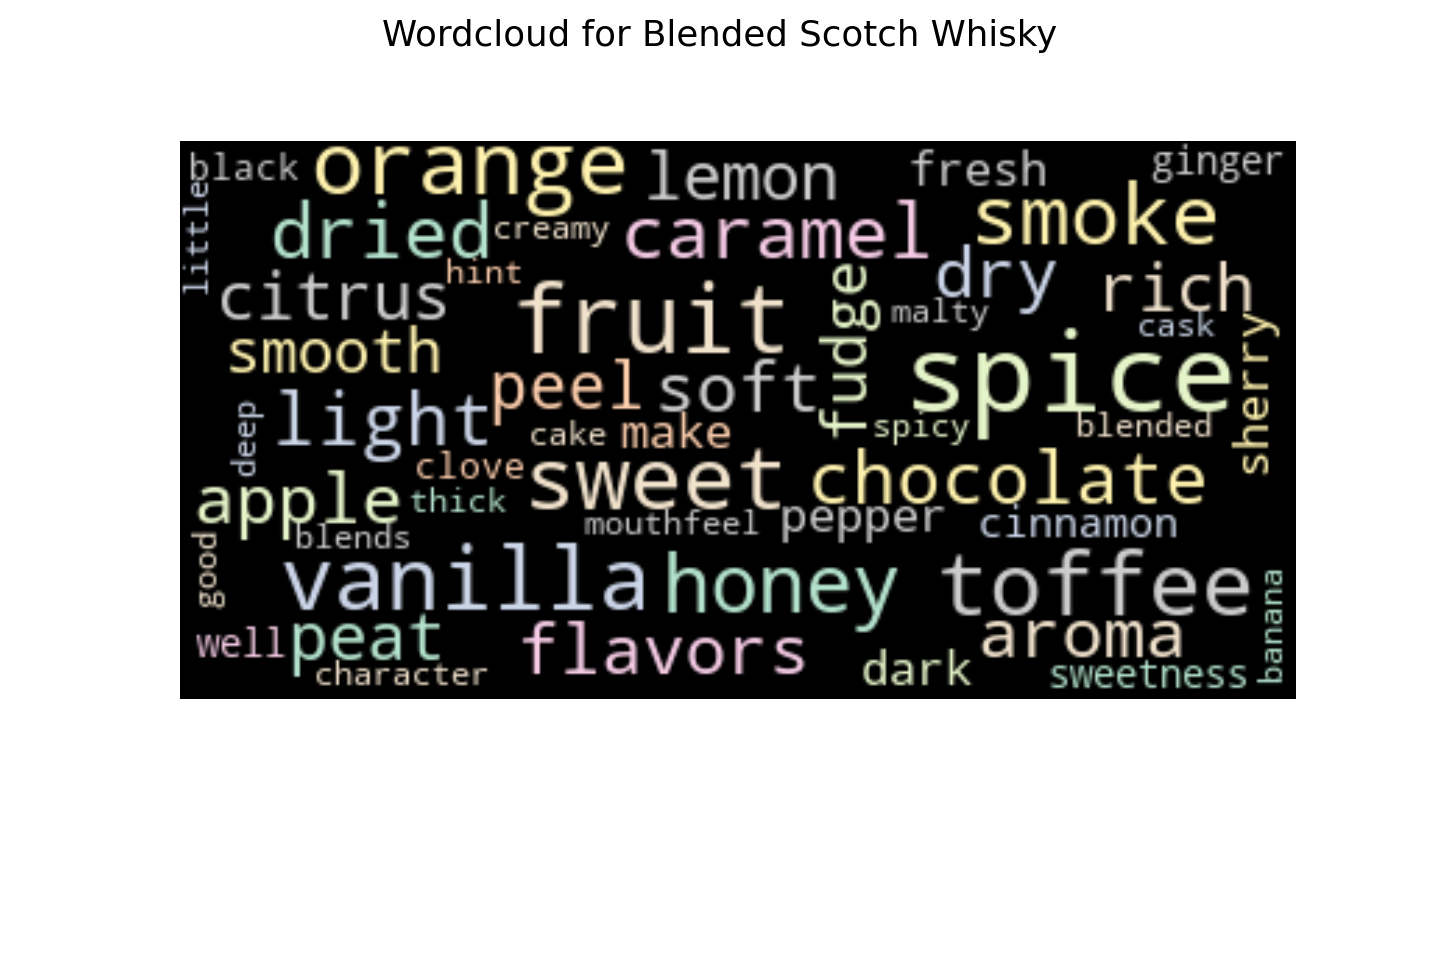

In [112]:
show_wordcloud(BSW,title="Wordcloud for Blended Scotch Whisky")

<IPython.core.display.Javascript object>


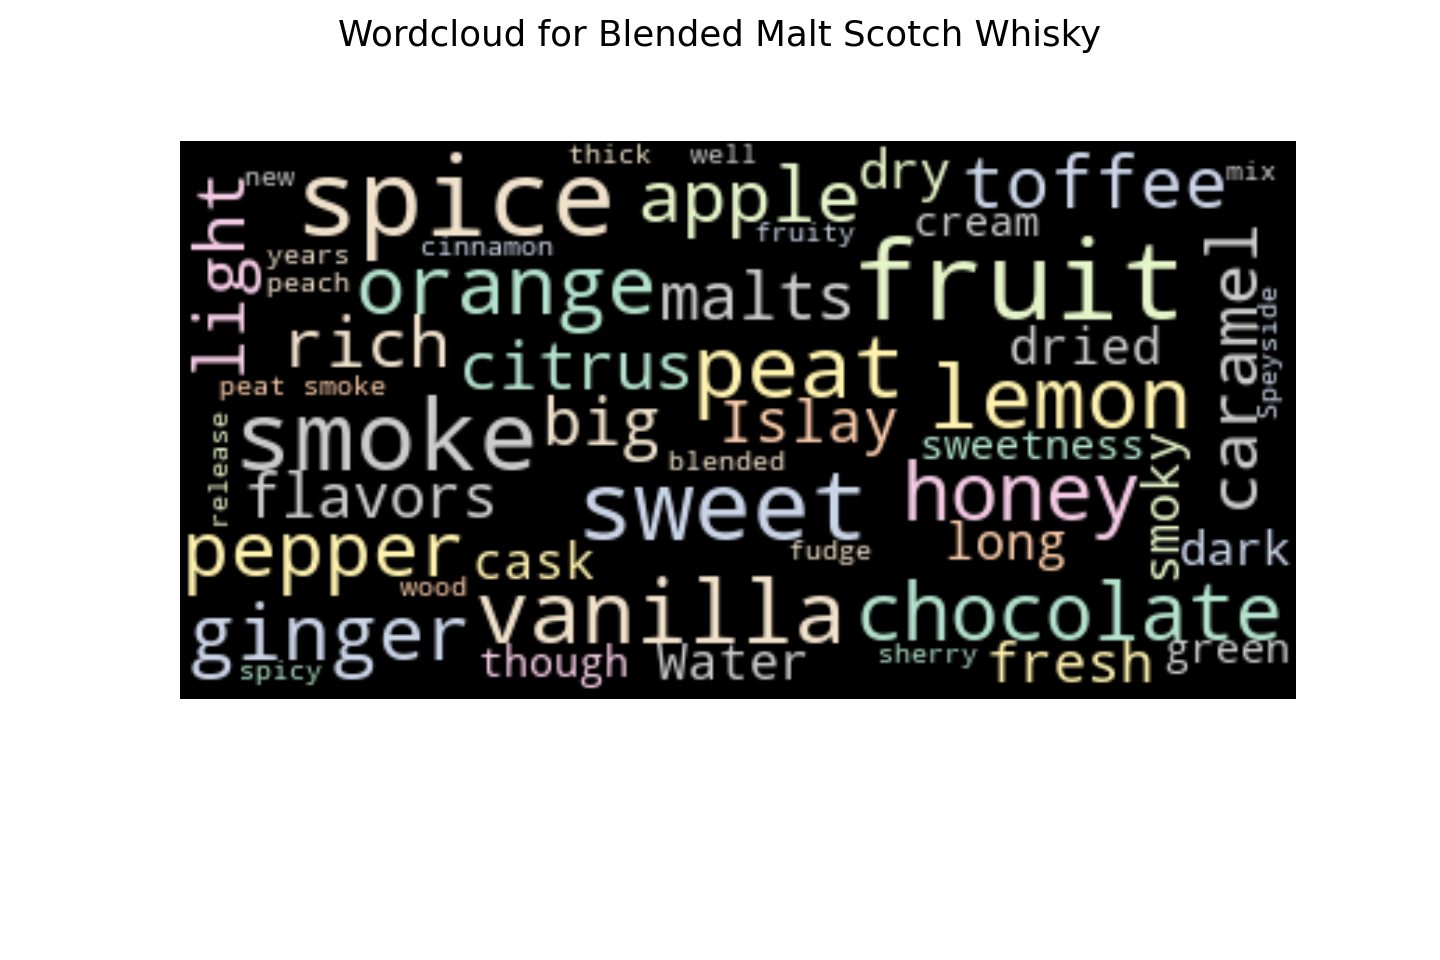

In [113]:
show_wordcloud(BMSW,title="Wordcloud for Blended Malt Scotch Whisky")

<IPython.core.display.Javascript object>


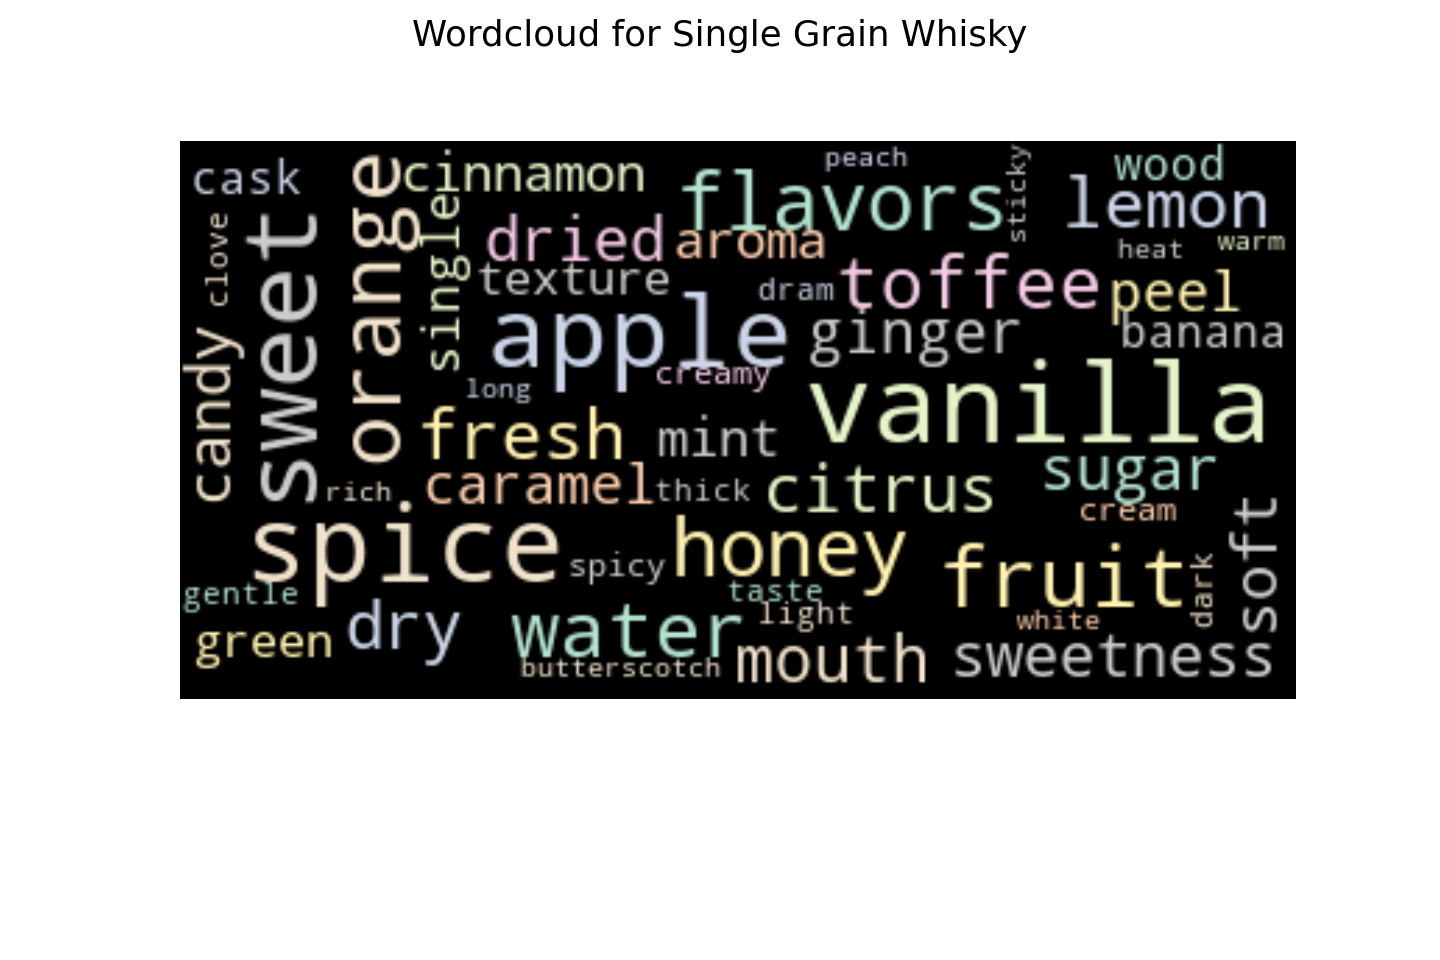

In [114]:
show_wordcloud(SGW,title="Wordcloud for Single Grain Whisky")

<IPython.core.display.Javascript object>


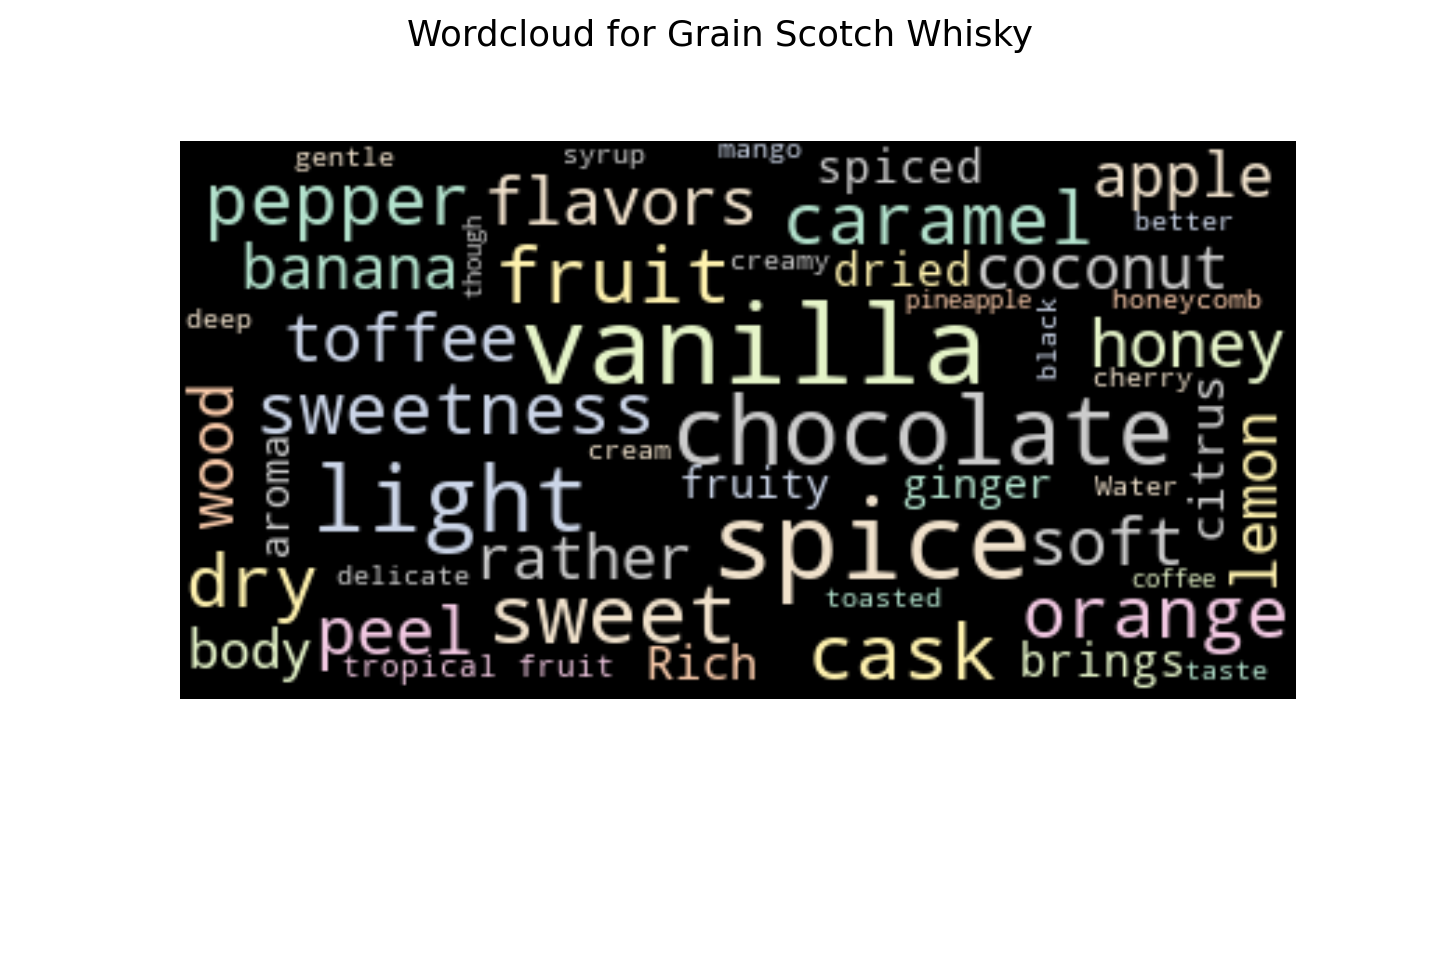

In [115]:
show_wordcloud(GSW,title="Wordcloud for Grain Scotch Whisky")

Hay 5 categorias. Podemos ver el rating.

-Valor mediano.

-Vemos tambien los valores anormales (outliners) para cada categoria.

<IPython.core.display.Javascript object>


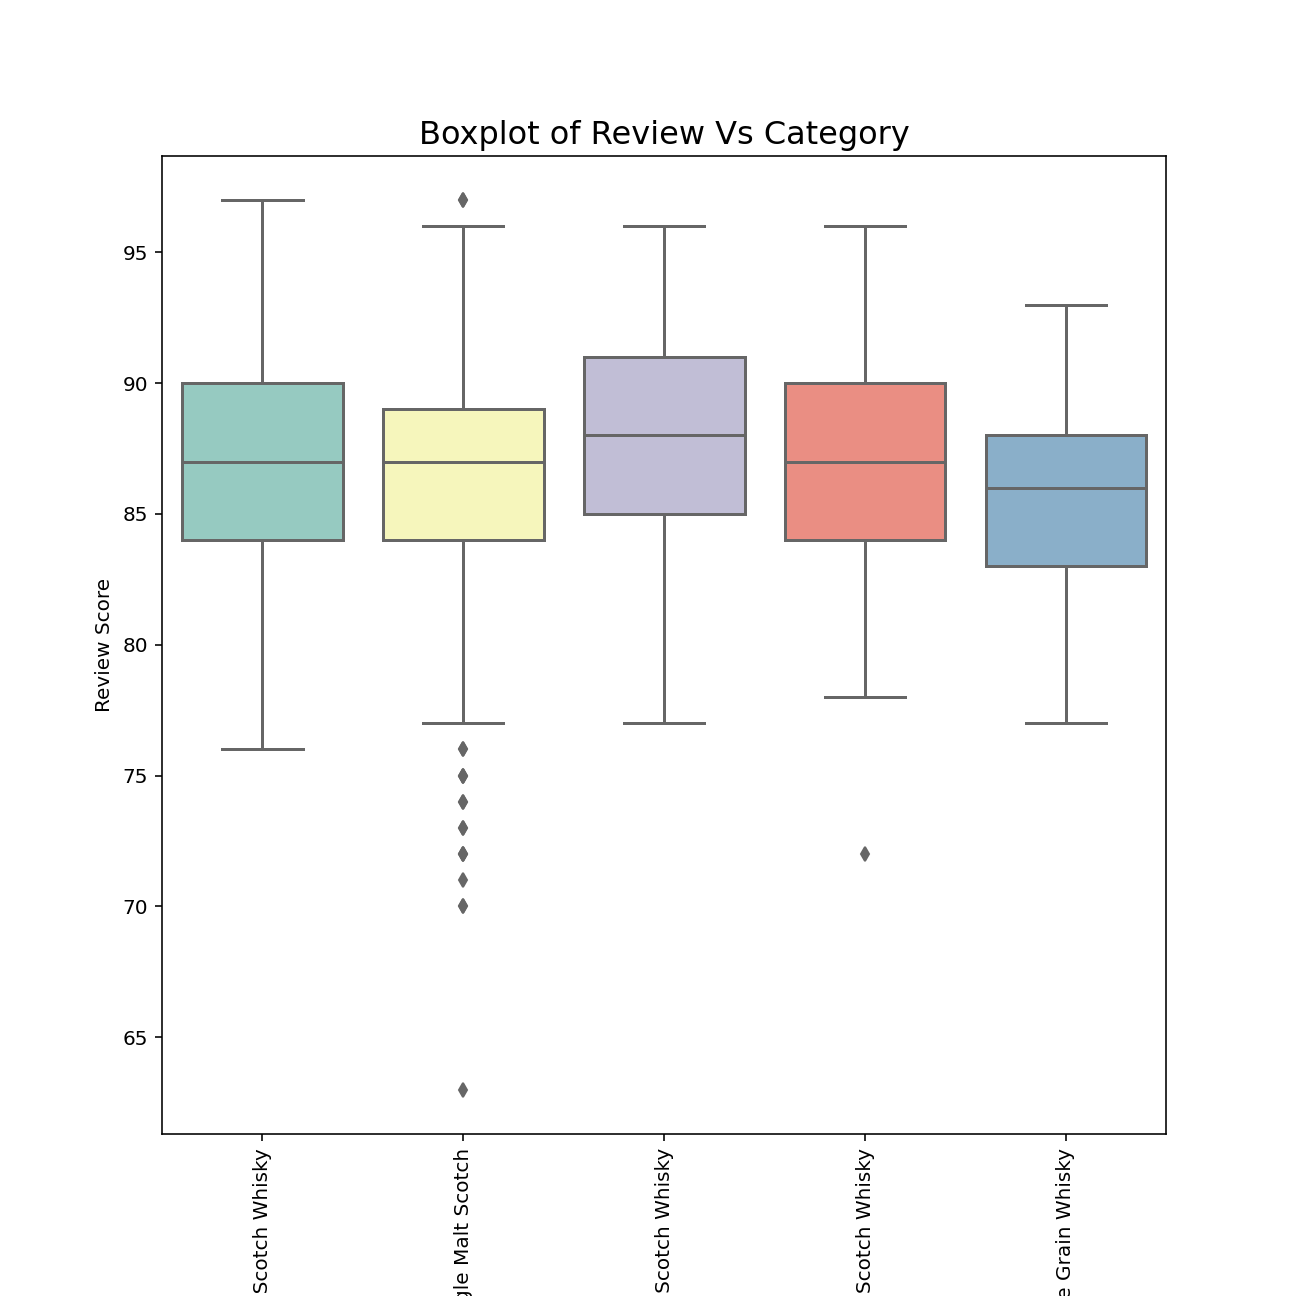

Text(0, 0.5, 'Review Score')

In [116]:
plt.figure(figsize=(9,9))
p=sns.boxplot(df['category'],df['rating'],palette=sns.color_palette(palette='Set3'))
p.set_xticklabels(p.get_xticklabels(),rotation=90)
plt.title("Boxplot of Review Vs Category",size=16)
plt.xlabel('Category',size=10)
plt.ylabel('Review Score',size=10)

Tambien podemos asumir que hay una realacion entre el numero de años en barrica y la calidad, lo mismo sucede con la graduacion alcoholica. 

La columna "name" nos da esa informacion, pero debemos extraerla correctamente pues aparece mezclada con el texto.

In [117]:
df['age'] = df['name'].str.extract(r'(\d+) year')[0].astype(float)

df['alcohol%'] = df['name'].str.extract(r"([\(\,\,\'\"\’\”\$] ? ?\d+(\.\d+)?%)")[0]
df['alcohol%'] = df['alcohol%'].str.replace("[^\d\.]", "").astype(float)

df[['name', 'age', 'alcohol%']]

,name,age,alcohol%
0,"Johnnie Walker Blue Label, 40%",NaN,40.0
1,"Black Bowmore, 1964 vintage, 42 year old, 40.5%",42.0,40.5
2,"Bowmore 46 year old (distilled 1964), 42.9%",46.0,42.9
3,"Compass Box The General, 53.4%",NaN,53.4
4,"Chivas Regal Ultis, 40%",NaN,40.0
...,...,...,...
2242,"Duncan Taylor (distilled at Cameronbridge), Ca...",28.0,54.4
2243,Distillery Select 'Craiglodge' (distilled at L...,8.0,45.0
2244,"Edradour Barolo Finish, 11 year old, 57.1%",11.0,57.1
2245,"Highland Park, Cask #7380, 1981 vintage, 25 ye...",25.0,55.0


Ahora veremos si el numero de elementos del cual tenemos el valor "age" es representativo

In [118]:
df.describe()

,Index,rating,price,age,alcohol%,Adjectives Ranking
count,2247.000000,2247.000000,2247.000000,1214.000000,2229.000000,2247.000000
mean,1124.000000,86.700045,643.117490,20.925041,47.890664,31.760814
std,648.797349,4.054055,4702.631546,10.024873,5.860633,21.701927
min,1.000000,63.000000,12.000000,3.000000,40.000000,0.000000
25%,562.500000,84.000000,70.000000,13.000000,43.000000,12.870000
50%,1124.000000,87.000000,110.000000,18.000000,46.000000,29.535000
75%,1685.500000,90.000000,200.000000,26.000000,52.100000,46.845000
max,2247.000000,97.000000,157000.000000,70.000000,67.400000,98.760000


In [119]:
df[['age']].isnull().sum()

age    1033
dtype: int64

Solo menos del 50% de los elementos tienen informacion sobre 'age', con lo cual no es un dato bueno para nuestra regresion.

In [120]:
df[['alcohol%']].isnull().sum()

alcohol%    18
dtype: int64

Sin embargo tenemos informacion acerca de la graduacion alcoholica de casi todos los elementos.

En las siguientes graficas podemos ver como se distribuyen la edad y graduacion alcoholica de los whiskies 
comparado con el rating.

<IPython.core.display.Javascript object>


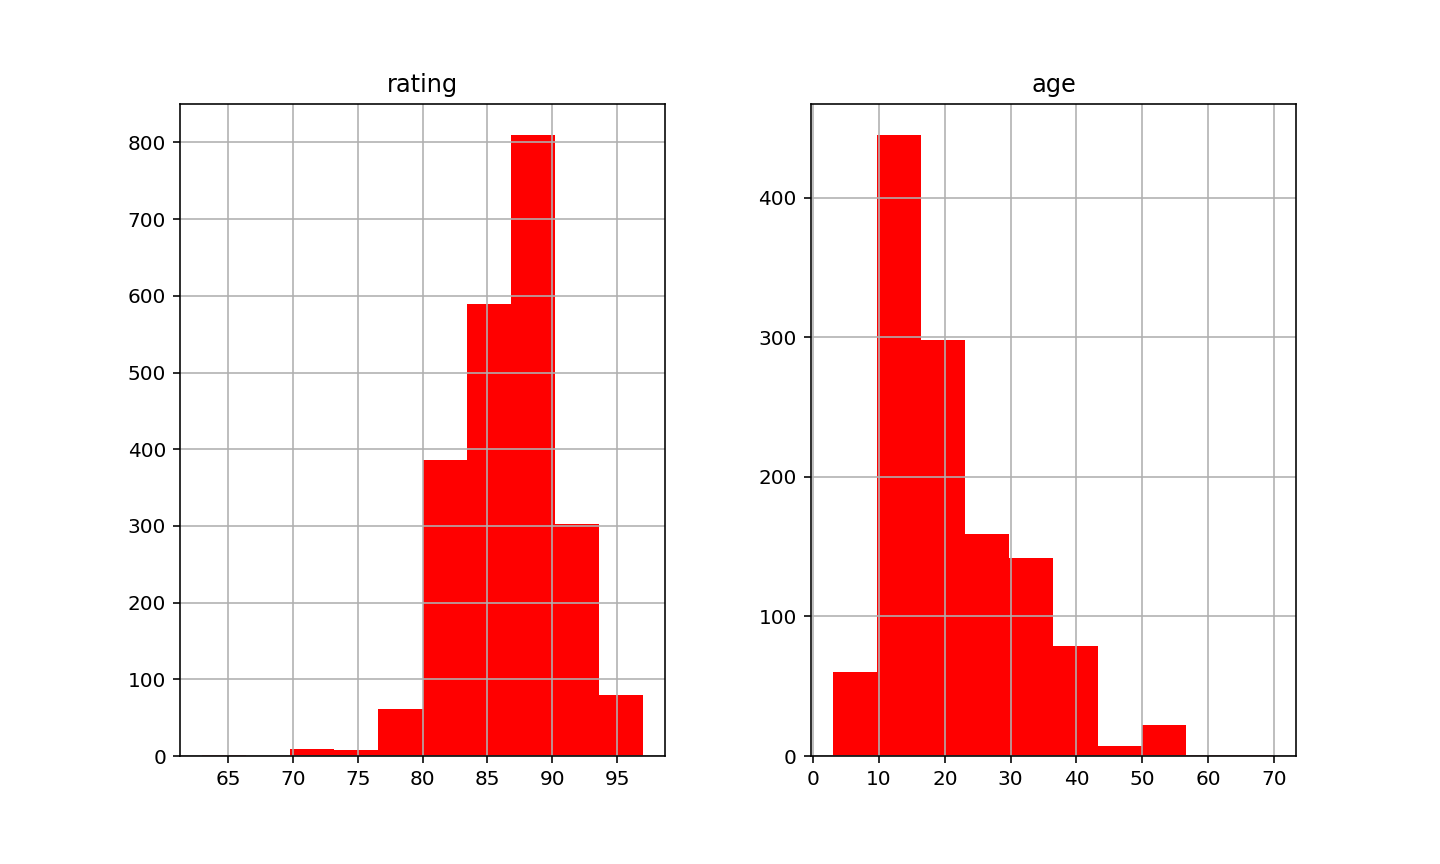

In [121]:
attributes = ['rating', 'age']

df[attributes].hist(figsize = (10, 6), color = 'red');

<IPython.core.display.Javascript object>


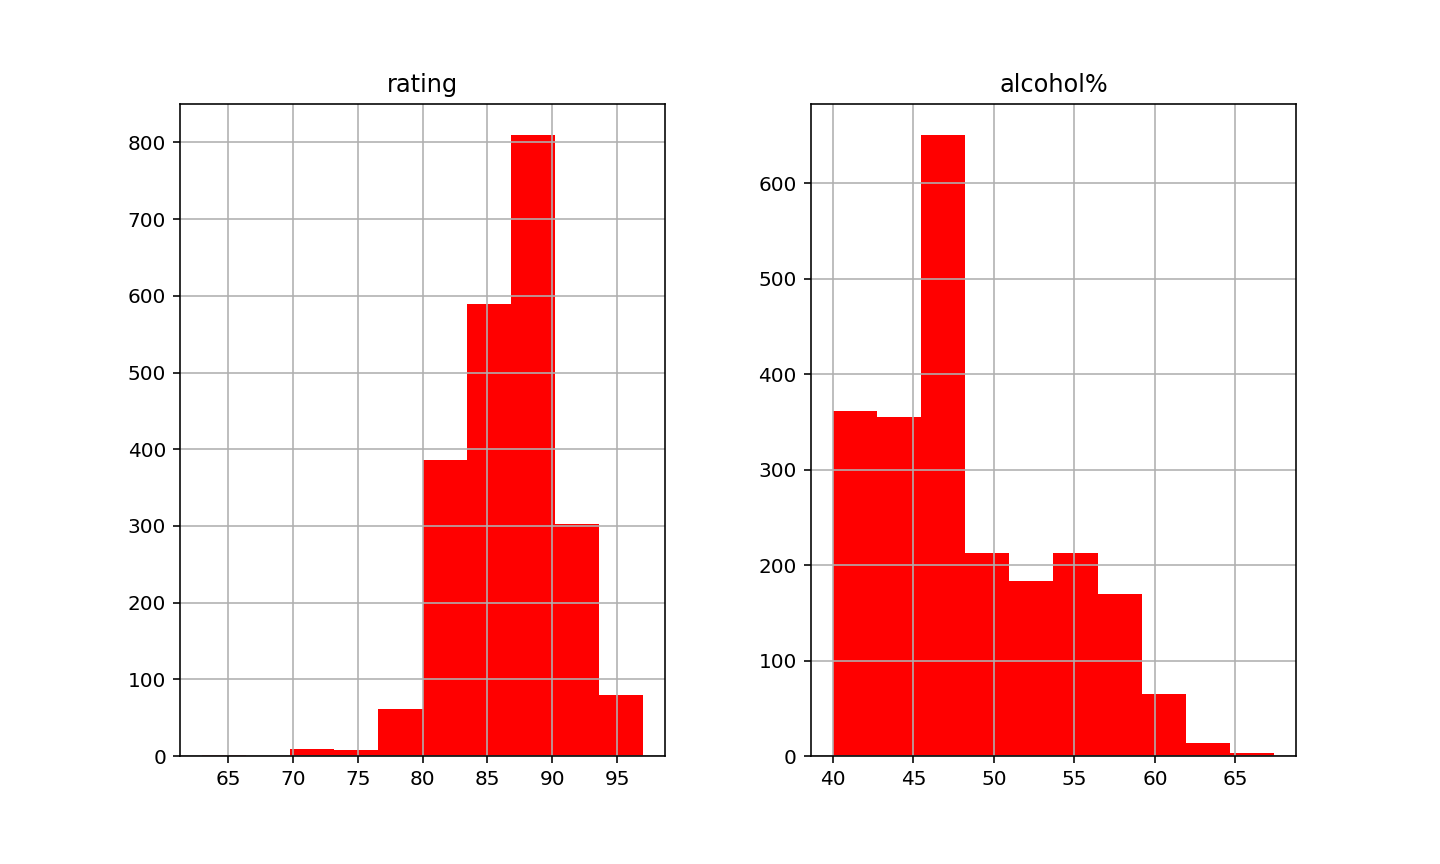

In [122]:
attributes = ['rating', 'alcohol%']

df[attributes].hist(figsize = (10, 6), color = 'red');

Vimos anteriormente que tenemos 5 categorias de whisky. Vamos a ver como se distribuyen los rating en funcion de cada una.

<IPython.core.display.Javascript object>


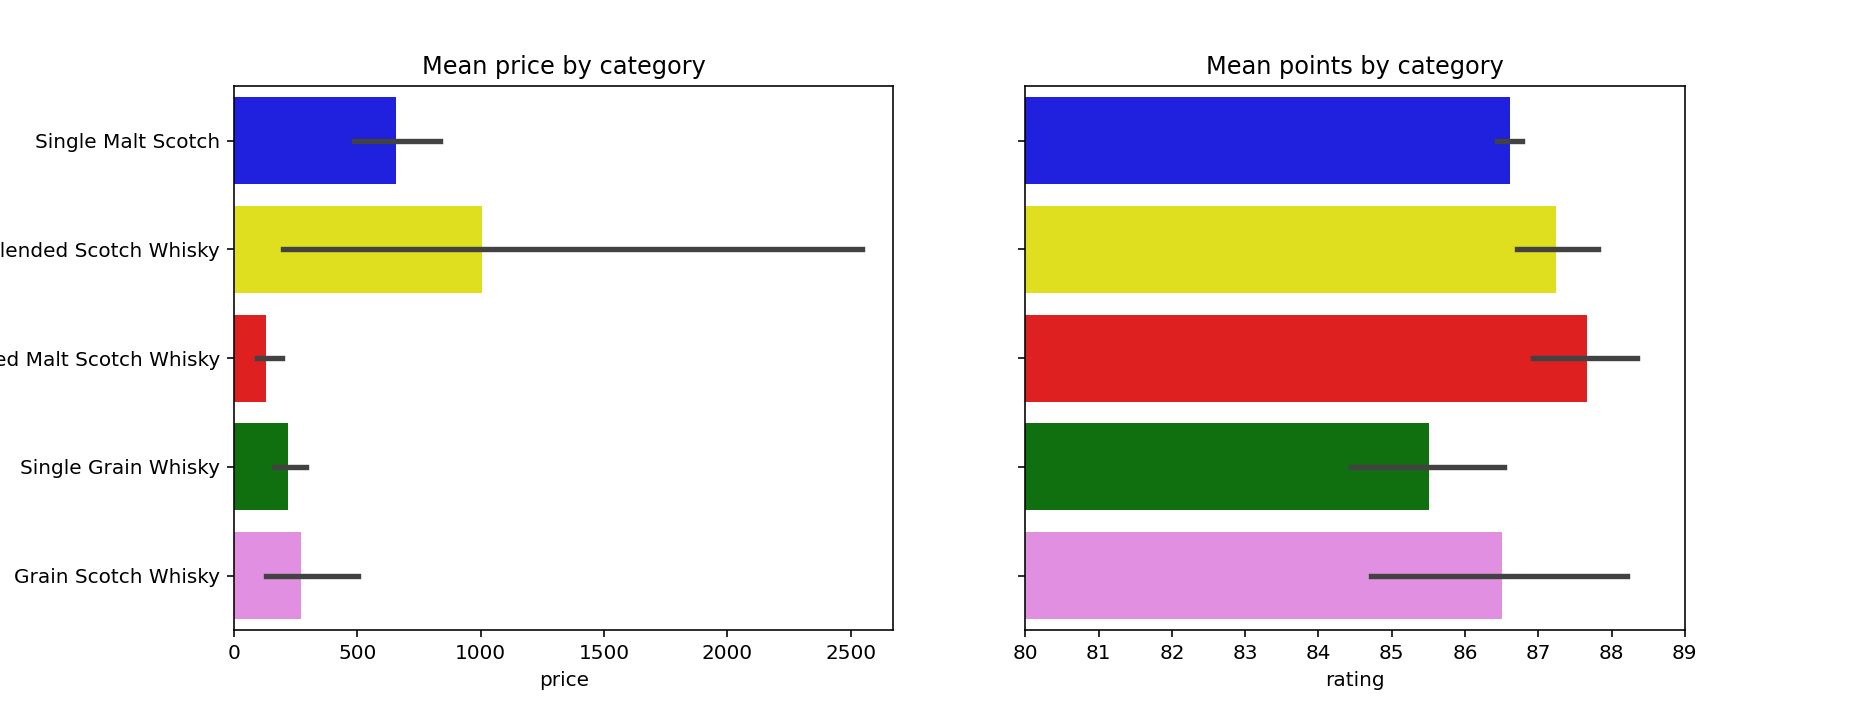

In [123]:
colors = ['blue', 'yellow', 'red', 'green', 'violet']
categories_index = df['category'].value_counts().index

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (13, 5))

ax1.set_title('Mean price by category')
sns.barplot(x = 'price', y = 'category', data = df, order = categories_index, palette = colors, ax = ax1)

ax2.set_title('Mean points by category')
sns.barplot(x = 'rating', y = 'category', data = df, order = categories_index, palette = colors, ax = ax2)
ax2.set(yticklabels = [])
ax2.set_ylabel('')
ax2.set_xlim(80, 89);

Vemos el dataset tras hacer las transformaciones anteriores.

In [130]:
df.head(10)

,Index,name,category,rating,price,description,age,alcohol%,Adjectives Ranking
0,1,"Johnnie Walker Blue Label, 40%",Blended Scotch Whisky,97,225.0,"Magnificently powerful and intense. Caramels, ...",NaN,40.0,56.355
1,2,"Black Bowmore, 1964 vintage, 42 year old, 40.5%",Single Malt Scotch,97,4500.0,What impresses me most is how this whisky evol...,42.0,40.5,22.530
2,3,"Bowmore 46 year old (distilled 1964), 42.9%",Single Malt Scotch,97,13500.0,There have been some legendary Bowmores from t...,46.0,42.9,24.180
3,4,"Compass Box The General, 53.4%",Blended Malt Scotch Whisky,96,325.0,With a name inspired by a 1926 Buster Keaton m...,NaN,53.4,26.130
4,5,"Chivas Regal Ultis, 40%",Blended Malt Scotch Whisky,96,160.0,"Captivating, enticing, and wonderfully charmin...",NaN,40.0,38.100
5,6,"Ardbeg Corryvreckan, 57.1%",Single Malt Scotch,96,85.0,"Powerful, muscular, well-textured, and invigor...",NaN,57.1,12.750
6,7,"Gold Bowmore, 1964 vintage, 42.4%",Single Malt Scotch,96,6250.0,Deep gold color. Surprisingly lively on the no...,NaN,42.4,59.265
7,8,"Bowmore, 40 year old, 44.8%",Single Malt Scotch,96,11000.0,"Definitely showing its age, but not in a bad w...",40.0,44.8,0.000
8,9,"The Dalmore, 50 year old, 52.8%",Single Malt Scotch,96,1500.0,The Dalmore is one of a handful of whiskies th...,50.0,52.8,21.795
9,10,"Glenfarclas Family Casks 1954 Cask #1260, 47.2%",Single Malt Scotch,96,3360.0,A rich amber color and elegantly oxidized note...,NaN,47.2,59.715


Vamos a hacer nuestro modelo en funcion de las palabras relacionadas con el sabor del whisky que aparecen en las marcas con mejor rating. Veremos cuales son el top 10 de cada categoria de whisky, luego en funcion de las palabras mas comunes que vemos en la descripcion del sabor estableceremos nuestro modelo.

In [131]:
top_10_SMS = df[df['category'] == 'Single Malt Scotch'].nlargest(10, ['rating'])
top_10_SMS

,Index,name,category,rating,price,description,age,alcohol%,Adjectives Ranking
1,2,"Black Bowmore, 1964 vintage, 42 year old, 40.5%",Single Malt Scotch,97,4500.0,What impresses me most is how this whisky evol...,42.0,40.5,22.530
2,3,"Bowmore 46 year old (distilled 1964), 42.9%",Single Malt Scotch,97,13500.0,There have been some legendary Bowmores from t...,46.0,42.9,24.180
5,6,"Ardbeg Corryvreckan, 57.1%",Single Malt Scotch,96,85.0,"Powerful, muscular, well-textured, and invigor...",NaN,57.1,12.750
6,7,"Gold Bowmore, 1964 vintage, 42.4%",Single Malt Scotch,96,6250.0,Deep gold color. Surprisingly lively on the no...,NaN,42.4,59.265
7,8,"Bowmore, 40 year old, 44.8%",Single Malt Scotch,96,11000.0,"Definitely showing its age, but not in a bad w...",40.0,44.8,0.000
8,9,"The Dalmore, 50 year old, 52.8%",Single Malt Scotch,96,1500.0,The Dalmore is one of a handful of whiskies th...,50.0,52.8,21.795
9,10,"Glenfarclas Family Casks 1954 Cask #1260, 47.2%",Single Malt Scotch,96,3360.0,A rich amber color and elegantly oxidized note...,NaN,47.2,59.715
10,11,"The Glenlivet Cellar Collection, 1969 vintage,...",Single Malt Scotch,96,750.0,It’s great that Glenlivet releases whiskies un...,NaN,50.8,9.780
11,12,"Macallan 1976 Vintage, 29 year old, cask #1135...",Single Malt Scotch,96,1500.0,Classic sherry cask-aged Macallan. Antique amb...,29.0,45.4,9.780
17,18,"Ardbeg, 1974 Vintage, Cask #3145, 49.9%",Single Malt Scotch,95,20000.0,"Cask #3145 is the lighter in color, and the sw...",NaN,49.9,45.795


In [132]:
top_10_BMSW = df[df['category'] == 'Blended Malt Scotch Whisky'].nlargest(10, ['rating'])
top_10_BMSW

,Index,name,category,rating,price,description,age,alcohol%,Adjectives Ranking
3,4,"Compass Box The General, 53.4%",Blended Malt Scotch Whisky,96,325.0,With a name inspired by a 1926 Buster Keaton m...,NaN,53.4,26.130
4,5,"Chivas Regal Ultis, 40%",Blended Malt Scotch Whisky,96,160.0,"Captivating, enticing, and wonderfully charmin...",NaN,40.0,38.100
13,14,Compass Box Flaming Heart (10th Anniversary bo...,Blended Malt Scotch Whisky,95,105.0,"A marriage of three different single malts, ag...",NaN,48.9,45.795
38,39,"Compass Box The Peat Monster, 46%",Blended Malt Scotch Whisky,94,60.0,The formula for this whisky has changed slight...,NaN,46.0,33.615
76,77,"Blue Hanger 6th Release Berry Bros. & Rudd, 45.6%",Blended Malt Scotch Whisky,94,84.0,If you want proof that blended malts can be wo...,NaN,45.6,60.225
79,80,Collectivum XXVIII (Diageo Special Releases 20...,Blended Malt Scotch Whisky,94,164.0,An incredibly complex creation using stock fro...,NaN,57.3,60.105
80,81,"Compass Box Oak Cross, 46%",Blended Malt Scotch Whisky,93,50.0,This has long been a core whisky for Compass B...,NaN,46.0,75.180
81,82,Compass Box Flaming Heart 2015 Edition 15th An...,Blended Malt Scotch Whisky,93,150.0,Without dredging up all the brouhaha over the ...,NaN,48.9,46.845
82,83,"Compass Box Spice Tree Extravaganza, 46%",Blended Malt Scotch Whisky,93,140.0,"Recognizably Spice Tree, but it’s richer, more...",NaN,46.0,42.405
84,85,"Johnnie Walker Odyssey, 40%",Blended Malt Scotch Whisky,93,1100.0,Jim Beveridge delivered these aromas of toffee...,NaN,40.0,38.100


In [133]:
top_10_BSW = df[df['category'] == 'Blended Scotch Whisky'].nlargest(10, ['rating'])
top_10_BSW

,Index,name,category,rating,price,description,age,alcohol%,Adjectives Ranking
0,1,"Johnnie Walker Blue Label, 40%",Blended Scotch Whisky,97,225.0,"Magnificently powerful and intense. Caramels, ...",NaN,40.0,56.355
14,15,Compass Box The Peat Monster 10th Anniversary ...,Blended Scotch Whisky,95,120.0,"As you’d expect, solid peat is the first thing...",NaN,54.7,0.000
15,16,"Johnnie Walker Blue Anniversary, 60%",Blended Scotch Whisky,95,3500.0,Formulated to celebrate the 200th anniversary ...,NaN,60.0,46.845
16,17,"Chivas, 18 year old, 40%",Blended Scotch Whisky,95,70.0,An essay in balance on both the aroma and pala...,18.0,40.0,67.590
35,36,"The Last Drop, 1960 vintage, 48 year old, 52%",Blended Scotch Whisky,95,2000.0,A 12 year old blended whisky was created in 19...,48.0,52.0,12.750
36,37,"The Last Drop 50 year old, 50.9%",Blended Scotch Whisky,95,4000.0,Would you have gambled The Last Drop 1960 liqu...,50.0,50.9,25.350
39,40,"Compass Box Phenomenology, 46%",Blended Scotch Whisky,94,180.0,"The nose has honey, caramelized apples, Pixy S...",NaN,46.0,34.095
40,41,"Johnnie Walker The Casks Edition, 55.8%",Blended Scotch Whisky,94,300.0,You don't mess with the Johnnie Walker brand n...,NaN,55.8,74.790
41,42,"The John Walker, 40%",Blended Scotch Whisky,94,3500.0,The pinnacle of the current Johnnie Walker ran...,NaN,40.0,9.780
42,43,Chivas Regal 18 year old Ultimate Cask Collect...,Blended Scotch Whisky,94,120.0,"An auld alliance renewed, this gorgeous whisky...",18.0,48.0,17.835


In [134]:
top_10_SGW = df[df['category'] == 'Single Grain Whisky'].nlargest(10, ['rating'])
top_10_SGW

,Index,name,category,rating,price,description,age,alcohol%,Adjectives Ranking
158,159,Douglas Laing Old Particular (distilled at Car...,Single Grain Whisky,93,100.0,"You little beauty! Maple syrup, pecan, sliced ...",33.0,45.4,0.000
268,269,Douglas Laing Old Particular (distilled at Cam...,Single Grain Whisky,92,80.0,"A single cask from a refill hoggie, this burst...",25.0,62.0,34.095
270,271,Exclusive Malts (distilled at Cameronbridge) 1...,Single Grain Whisky,92,225.0,"Top notes of hay, honey, and caramel over a sp...",33.0,51.2,65.190
272,273,The Sovereign (distilled at Cambus) 30 year ol...,Single Grain Whisky,92,152.0,"The nose is bathed in aromas of lime, bergamot...",30.0,49.4,13.260
273,274,Duncan Taylor Rare Auld (distilled at Girvan) ...,Single Grain Whisky,92,450.0,"This is an assured release, one not trying to ...",40.0,53.7,50.220
274,275,"The Five Distinguished and Rare 39 year old, 51%",Single Grain Whisky,92,216.0,"This is massive. It even pours thickly, as the...",39.0,51.0,72.195
366,367,The Sovereign (distilled at Cambus) 50 year ol...,Single Grain Whisky,91,657.0,You really don’t see many of these. Pear drops...,50.0,49.2,46.845
555,556,Port Dundas 52 year old (Diageo Special Releas...,Single Grain Whisky,90,900.0,This 1964 distillate has a nose of rich toffee...,52.0,44.6,22.650
561,562,The Sovereign (distilled at Dumbarton) 50 year...,Single Grain Whisky,90,453.0,Incredible! This dark golden dram was distille...,50.0,43.8,75.450
562,563,"Caledonian ‘The Cally’ 1974 40 year old, 53.3%",Single Grain Whisky,90,1200.0,"If your glass is half empty, you might overloo...",40.0,53.3,77.940


In [135]:
top_10_GSW = df[df['category'] == 'Grain Scotch Whisky'].nlargest(10, ['rating'])
top_10_GSW

,Index,name,category,rating,price,description,age,alcohol%,Adjectives Ranking
12,13,The Last Drop (distilled at Lochside) 1972 (ca...,Grain Scotch Whisky,96,3108.0,A remarkable beauty from the Angus town of Mon...,NaN,44.0,47.355
37,38,"Duncan Taylor (distilled at Invergordon), 40 y...",Grain Scotch Whisky,94,225.0,A really stunning grain whisky. So rich for a ...,40.0,49.7,22.650
161,162,Exclusive Malts (distilled at Invergordon) 43 ...,Grain Scotch Whisky,93,260.0,This grand old Highlander brings warm flapjack...,43.0,48.2,12.480
173,174,"Compass Box Hedonism Quindecimus, 46%",Grain Scotch Whisky,92,200.0,How time flies! This eloquent blended grain ma...,NaN,46.0,46.845
388,389,Compass Box Hedonism Maximus,Grain Scotch Whisky,90,300.0,"An older, more exotic expression of Hedonism, ...",NaN,NaN,25.350
518,519,Scott's Selection (Distilled at 'North of Scot...,Grain Scotch Whisky,90,140.0,According to the Christie family who owned Nor...,NaN,45.5,63.090
539,540,That Boutique-y Whisky Company (distilled at N...,Grain Scotch Whisky,90,51.0,This slippery little rogue exudes sweet popcor...,27.0,56.3,50.220
543,544,Douglas Laing Xtra Old Particular (distilled a...,Grain Scotch Whisky,90,390.0,This is an amazing link back to Glasgow in the...,40.0,55.4,0.000
752,753,"The Exceptional Grain, 43%",Grain Scotch Whisky,89,100.0,The debut release from Don Sutcliffe's Sutclif...,NaN,43.0,11.700
931,932,The Clan Denny Single Grain (distilled at Camb...,Grain Scotch Whisky,88,190.0,Very typical of old grain whiskies: light in b...,35.0,54.2,24.180


Vamos a usar la libreria spacy para hacer nuestro trabajo NLP.

Primero separamos los adjetivos de la parte de descripcion.

In [136]:
import spacy
from spacy.lang.en.stop_words import STOP_WORDS

nlp = spacy.load("en_core_web_sm")


description_text =''

for h in df['description']:
    description_text = description_text + h

my_doc = nlp(description_text)


print("Adjectives:", [token.lemma_ for token in my_doc if token.pos_ == "ADJ"])



Adjectives: ['powerful', 'intense', 'elegant', 'cigar', 'new', 'satisfying', 'silky', 'bountiful', 'ripe', 'pervasive', 'dry', 'close', 'complex', 'thick', 'viscous', 'whisky', 'sticky', 'earthy', 'roasted', 'fallen', 'black', 'ripe', 'dark', 'polished', 'wild', 'leafy', 'damp', 'old', 'legendary', 'equal', 'remarkable', 'tropical', 'hallucinatory', 'light', 'more', 'concentrated', 'low', 'silky', 'heady', 'dry', 'more', 'old', 'cheap', 'superb', 'rich', 'dusty', 'old', 'fresh', 'surprising', 'back', 'charming', 'first', 'red', 'heather', 'rich', 'satisfying', 'dark', 'choicepowerful', 'muscular', 'aggressive', 'damp', 'smoked', 'black', 'black', 'dark', 'stunning!deep', 'lively', 'complex', 'pink', 'general', 'overall', 'citrus', 'old', 'damp', 'sweet', 'lively', 'visceral', 'juicy', 'deep', 'subtle', 'charred', 'roasted', 'well', 'soft', 'vibrant', 'bad', 'solid', 'thick', 'old', 'golden', 'soft', 'seductive', 'juicy', 'excellent', 'fine', 'able', 'many', 'viscous', 'heavy', 'old', '

Añadimos esos adjetivos a una variable del tipo list

In [137]:
whisky_adj = [token.lemma_ for token in my_doc if (token.pos_ == "ADJ") and (token.lemma_ != "more") and 
              (token.lemma_ != "old") and (token.lemma_ != "good") and (token.lemma_ != "black") 
              and (token.lemma_ != "single")]

Vemos cuantas veces aparece cada uno

In [138]:
from collections import defaultdict

occurrence = defaultdict(lambda: 0)

for adjective in whisky_adj:
    occurrence[adjective] += 1

for key, value in occurrence.items():
    print(f"{key}={value}")

powerful=35
intense=62
elegant=61
cigar=12
new=209
satisfying=17
silky=52
bountiful=2
ripe=250
pervasive=1
dry=319
close=11
complex=178
thick=155
viscous=57
whisky=44
sticky=33
earthy=109
roasted=86
fallen=6
dark=326
polished=122
wild=11
leafy=18
damp=62
legendary=7
equal=4
remarkable=10
tropical=119
hallucinatory=1
light=299
concentrated=32
low=23
heady=4
cheap=1
superb=10
rich=329
dusty=29
fresh=339
surprising=17
back=14
charming=7
first=222
red=180
heather=35
choicepowerful=1
muscular=8
aggressive=16
smoked=23
stunning!deep=1
lively=97
pink=8
general=11
overall=8
citrus=76
sweet=871
visceral=6
juicy=58
deep=105
subtle=231
charred=19
well=52
soft=412
vibrant=50
bad=10
solid=30
golden=76
seductive=13
excellent=39
fine=34
able=4
many=57
heavy=51
classic=81
bedding=2
almond=29
rare=31
lucky=3
few=33
luscious=17
like=104
balanced=127
fragile=7
real=37
long=227
fair=6
great=141
true=25
ultra=15
-=83
matured=5
least=10
tired=14
aged=76
antique=19
exceptional=7
multi=7
faceted=4
liquid=7
fr

Los ordenamos por frecuencia de aparicion

In [139]:
import operator

sorted_adj = dict( sorted(occurrence.items(), key=operator.itemgetter(1),reverse=True))
print('Dictionary in descending order by value : ',sorted_adj)

Dictionary in descending order by value :  {'sweet': 871, 'spicy': 456, 'soft': 412, 'fresh': 339, 'rich': 329, 'dark': 326, 'dry': 319, 'light': 299, 'ripe': 250, 'subtle': 231, 'long': 227, 'first': 222, 'new': 209, 'gentle': 201, 'full': 199, 'creamy': 197, 'little': 197, 'clean': 183, 'red': 180, 'orange': 180, 'complex': 178, 'floral': 176, 'smoky': 169, 'thick': 155, 'nutty': 153, 'green': 145, 'big': 144, 'white': 144, 'young': 143, 'great': 141, 'honeyed': 141, 'available': 136, 'medium': 128, 'balanced': 127, 'american': 127, 'polished': 122, 'tropical': 119, 'lengthy': 112, 'earthy': 109, 'delicate': 107, 'deep': 105, 'like': 104, 'fragrant': 103, 'smooth': 99, 'lively': 97, 'bright': 94, 'nice': 94, 'plain': 94, 'mature': 93, 'herbal': 92, 'bodied': 92, 'other': 88, 'bitter': 88, 'roasted': 86, 'oloroso': 86, '-': 83, 'warm': 83, 'classic': 81, 'early': 81, 'high': 77, 'citrus': 76, 'golden': 76, 'aged': 76, 'late': 75, 'oily': 71, 'limited': 70, 'rounded': 70, 'hot': 70, 'n

Nos interesan los 10 adjetivos mas comunes, pero vemos que entre ellos tenemos varios que no aportan nada para describir el sabor del whisky. Los excluimos cuando creamos la lista (3 bloques de codigo mas arriba)

In [140]:
from collections import Counter

k = Counter(sorted_adj)

top_10 = k.most_common(10)

for i in top_10:
    print(i[0]," :",i[1]," ")

sweet  : 871  
spicy  : 456  
soft  : 412  
fresh  : 339  
rich  : 329  
dark  : 326  
dry  : 319  
light  : 299  
ripe  : 250  
subtle  : 231  


Convertimos los valores a base 100, asi:

Sweet: 22.73 
Spicy: 11.89 
Soft:  10.75 
Fresh:  8.84 
Dry:    8.32 
Rich:   8.58 
Dark:   8.50 
Light:  7.80 
Ripe:   6.52 
Subtle: 6.03 

Ahora creamos un Diccionario

In [141]:
adj_mapping = {'sweet': 22.73, 'spicy': 11.89, 'soft': 10.75, 'fresh': 8.84, 'dry': 8.32, 'dark': 8.50, 
               'rich': 8.58, 'light': 7.80, 'ripe': 6.52, 'subtle': 6.03 }

Ahora creamos una lista homegeizando los valores de los adjetivos en base 100 para poder compararlos con el rating (tambien en base 100)

In [142]:
new_rank = []
mystring1 = df['description']
for i in mystring1:
    total_rank1 = 0

    for key in adj_mapping:
        if key in i:
            total_rank1 += adj_mapping[key]
    new_rank.append(total_rank1)
print(new_rank)

[37.57, 15.02, 16.12, 17.42, 25.4, 8.5, 39.510000000000005, 0, 14.530000000000001, 39.81, 6.52, 6.52, 31.57, 30.53, 0, 31.23, 45.06, 30.53, 22.73, 16.3, 13.83, 16.64, 51.260000000000005, 11.89, 0, 8.32, 39.63, 0, 8.5, 15.1, 0, 62.790000000000006, 18.41, 8.84, 18.41, 8.5, 16.9, 15.1, 22.41, 22.73, 49.86, 6.52, 11.89, 18.41, 8.5, 11.89, 6.52, 0, 40.0, 30.53, 16.12, 0, 49.64, 10.75, 51.52, 16.64, 0, 17.34, 30.53, 11.89, 39.37, 22.73, 57.470000000000006, 18.55, 39.55, 8.5, 12.55, 10.75, 22.73, 0, 8.58, 30.53, 8.5, 8.5, 16.38, 19.25, 40.15, 19.25, 50.92, 40.07, 50.120000000000005, 31.23, 28.27, 8.32, 25.4, 8.84, 10.75, 8.32, 45.660000000000004, 25.4, 31.310000000000002, 33.480000000000004, 22.73, 6.03, 16.9, 7.8, 10.75, 0, 16.64, 33.480000000000004, 59.760000000000005, 42.32000000000001, 17.16, 11.89, 11.89, 22.82, 8.84, 27.13, 17.08, 0, 8.58, 31.57, 29.25, 49.78, 6.03, 0, 11.89, 26.99, 8.58, 0, 37.34, 0, 22.330000000000002, 28.76, 18.55, 0, 26.42, 16.78, 0, 8.58, 43.2, 20.21, 13.83, 8.32, 

Vemos cual es el valor maximo

In [143]:
max(new_rank)

65.84

Multiplicamos todos los valores por 1.5 para poder compararlos con el rating (65.84 * 1.5 aprox 100)

In [144]:
new_rank_mod = [k * 1.5 for k in new_rank]
print(new_rank_mod)
max(new_rank_mod)


[56.355000000000004, 22.53, 24.18, 26.130000000000003, 38.099999999999994, 12.75, 59.26500000000001, 0.0, 21.795, 59.715, 9.78, 9.78, 47.355000000000004, 45.795, 0.0, 46.845, 67.59, 45.795, 34.095, 24.450000000000003, 20.745, 24.96, 76.89000000000001, 17.835, 0.0, 12.48, 59.44500000000001, 0.0, 12.75, 22.65, 0.0, 94.185, 27.615000000000002, 13.26, 27.615000000000002, 12.75, 25.349999999999998, 22.65, 33.615, 34.095, 74.78999999999999, 9.78, 17.835, 27.615000000000002, 12.75, 17.835, 9.78, 0.0, 60.0, 45.795, 24.18, 0.0, 74.46000000000001, 16.125, 77.28, 24.96, 0.0, 26.009999999999998, 45.795, 17.835, 59.05499999999999, 34.095, 86.20500000000001, 27.825000000000003, 59.324999999999996, 12.75, 18.825000000000003, 16.125, 34.095, 0.0, 12.870000000000001, 45.795, 12.75, 12.75, 24.57, 28.875, 60.224999999999994, 28.875, 76.38, 60.105000000000004, 75.18, 46.845, 42.405, 12.48, 38.099999999999994, 13.26, 16.125, 12.48, 68.49000000000001, 38.099999999999994, 46.965, 50.220000000000006, 34.095, 

98.76

Creamos una nueva columna con los valores

In [145]:
df['Adjectives Ranking'] = new_rank_mod
df.head(10)

,Index,name,category,rating,price,description,age,alcohol%,Adjectives Ranking
0,1,"Johnnie Walker Blue Label, 40%",Blended Scotch Whisky,97,225.0,"Magnificently powerful and intense. Caramels, ...",NaN,40.0,56.355
1,2,"Black Bowmore, 1964 vintage, 42 year old, 40.5%",Single Malt Scotch,97,4500.0,What impresses me most is how this whisky evol...,42.0,40.5,22.530
2,3,"Bowmore 46 year old (distilled 1964), 42.9%",Single Malt Scotch,97,13500.0,There have been some legendary Bowmores from t...,46.0,42.9,24.180
3,4,"Compass Box The General, 53.4%",Blended Malt Scotch Whisky,96,325.0,With a name inspired by a 1926 Buster Keaton m...,NaN,53.4,26.130
4,5,"Chivas Regal Ultis, 40%",Blended Malt Scotch Whisky,96,160.0,"Captivating, enticing, and wonderfully charmin...",NaN,40.0,38.100
5,6,"Ardbeg Corryvreckan, 57.1%",Single Malt Scotch,96,85.0,"Powerful, muscular, well-textured, and invigor...",NaN,57.1,12.750
6,7,"Gold Bowmore, 1964 vintage, 42.4%",Single Malt Scotch,96,6250.0,Deep gold color. Surprisingly lively on the no...,NaN,42.4,59.265
7,8,"Bowmore, 40 year old, 44.8%",Single Malt Scotch,96,11000.0,"Definitely showing its age, but not in a bad w...",40.0,44.8,0.000
8,9,"The Dalmore, 50 year old, 52.8%",Single Malt Scotch,96,1500.0,The Dalmore is one of a handful of whiskies th...,50.0,52.8,21.795
9,10,"Glenfarclas Family Casks 1954 Cask #1260, 47.2%",Single Malt Scotch,96,3360.0,A rich amber color and elegantly oxidized note...,NaN,47.2,59.715


Las filas en las que 'Age' y Alcohol es NaN lo reemplazamos por el valor medio.

In [146]:
df['age'].fillna(df['age'].dropna().median(), inplace=True)

In [147]:
df['alcohol%'].fillna(df['alcohol%'].dropna().median(), inplace=True)

Solo usamos las filas en que Adjectives Ranking es mayor que 0

In [148]:
df = df[df['Adjectives Ranking'] >= 0]

In [149]:
# Dividimos los datos 70% para training 30% test

msk = np.random.rand(len(df)) <= 0.7

train_df = df[msk]
test_df = df[~msk]

In [150]:
print(train_df.columns.values)

['Index' 'name' 'category' 'rating' 'price' 'description' 'age' 'alcohol%'
 'Adjectives Ranking']


Eliminamos valores no numericos

In [151]:
train_df = train_df.drop(['name', 'category', 'description'], axis=1)
test_df = test_df.drop(['name', 'category', 'description'], axis=1)

Vemos como queda nuestra tabla

In [152]:
train_df.head(10)

,Index,rating,price,age,alcohol%,Adjectives Ranking
1,2,97,4500.0,42.0,40.5,22.530
2,3,97,13500.0,46.0,42.9,24.180
3,4,96,325.0,18.0,53.4,26.130
5,6,96,85.0,18.0,57.1,12.750
7,8,96,11000.0,40.0,44.8,0.000
8,9,96,1500.0,50.0,52.8,21.795
9,10,96,3360.0,18.0,47.2,59.715
11,12,96,1500.0,29.0,45.4,9.780
13,14,95,105.0,18.0,48.9,45.795
15,16,95,3500.0,18.0,60.0,46.845


In [153]:
print(test_df.columns.values)

['Index' 'rating' 'price' 'age' 'alcohol%' 'Adjectives Ranking']


In [154]:
train_df.describe()

,Index,rating,price,age,alcohol%,Adjectives Ranking
count,1533.000000,1533.000000,1533.000000,1533.000000,1533.000000,1533.000000
mean,1125.437704,86.696021,644.133725,19.575995,47.830913,31.289305
std,646.452984,4.010133,3686.575413,7.611332,5.799535,21.854077
min,2.000000,70.000000,12.000000,3.000000,40.000000,0.000000
25%,569.000000,84.000000,70.000000,18.000000,43.000000,12.750000
50%,1138.000000,87.000000,109.000000,18.000000,46.000000,28.875000
75%,1689.000000,90.000000,200.000000,18.000000,52.000000,46.845000
max,2246.000000,97.000000,60000.000000,70.000000,67.400000,94.185000


# Regresion

Ahora vamos a hacer la regresion. Compararemos el rating real con el rating fundamentado en los adjetivos usados para describir el sabor de los diferentes whiskies.

Posiblemente no va a resultar muy bueno pues hay muchos elementos con valor 0.

In [155]:
X_train = train_df.drop("rating", axis=1)
Y_train = train_df["rating"]
X_test  = test_df.drop("Index", axis=1).copy()#makes copy of previous datafram before dropping the column
X_train.shape, Y_train.shape, X_test.shape

((1533, 5), (1533,), (714, 5))

In [170]:
# Logistic Regression

logreg = LogisticRegression()
logreg.fit(X_train, Y_train)
Y_pred = logreg.predict(X_test)
acc_log = round(logreg.score(X_train, Y_train) * 100, 2)
acc_log


14.87

In [157]:
coeff_df = pd.DataFrame(train_df.columns.delete(0))
coeff_df.columns = ['Feature']
coeff_df["Correlation"] = pd.Series(logreg.coef_[0])

coeff_df.sort_values(by='Correlation', ascending=False)

,Feature,Correlation
2,age,-0.000330
4,Adjectives Ranking,-0.000675
3,alcohol%,-0.000819
0,rating,-0.003008
1,price,-0.004879


In [158]:
# Support Vector Machines

svc = SVC()
svc.fit(X_train, Y_train)
Y_pred = svc.predict(X_test)
acc_svc = round(svc.score(X_train, Y_train) * 100, 2)
acc_svc

36.4

In [159]:
knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_train, Y_train)
Y_pred = knn.predict(X_test)
acc_knn = round(knn.score(X_train, Y_train) * 100, 2)
acc_knn

92.5

In [160]:
# Gaussian Naive Bayes

gaussian = GaussianNB()
gaussian.fit(X_train, Y_train)
Y_pred = gaussian.predict(X_test)
acc_gaussian = round(gaussian.score(X_train, Y_train) * 100, 2)
acc_gaussian

90.87

In [161]:
# Perceptron

perceptron = Perceptron()
perceptron.fit(X_train, Y_train)
Y_pred = perceptron.predict(X_test)
acc_perceptron = round(perceptron.score(X_train, Y_train) * 100, 2)
acc_perceptron

8.35

In [162]:
# Linear SVC

linear_svc = LinearSVC()
linear_svc.fit(X_train, Y_train)
Y_pred = linear_svc.predict(X_test)
acc_linear_svc = round(linear_svc.score(X_train, Y_train) * 100, 2)
acc_linear_svc

10.57

In [163]:
# Stochastic Gradient Descent

sgd = SGDClassifier()
sgd.fit(X_train, Y_train)
Y_pred = sgd.predict(X_test)
acc_sgd = round(sgd.score(X_train, Y_train) * 100, 2)
acc_sgd

12.13

In [164]:
# Decision Tree

decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, Y_train)
Y_pred = decision_tree.predict(X_test)
acc_decision_tree = round(decision_tree.score(X_train, Y_train) * 100, 2)
acc_decision_tree

100.0

In [165]:
# Random Forest

random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, Y_train)
Y_pred = random_forest.predict(X_test)
random_forest.score(X_train, Y_train)
acc_random_forest = round(random_forest.score(X_train, Y_train) * 100, 2)
acc_random_forest

100.0

In [166]:
models = pd.DataFrame({
    'Model': ['Support Vector Machines', 'KNN', 'Logistic Regression', 
              'Random Forest', 'Naive Bayes', 'Perceptron', 
              'Stochastic Gradient Decent', 'Linear SVC', 
              'Decision Tree'],
    'Score': [acc_svc, acc_knn, acc_log, 
              acc_random_forest, acc_gaussian, acc_perceptron, 
              acc_sgd, acc_linear_svc, acc_decision_tree]})
models.sort_values(by='Score', ascending=False)

,Model,Score
3,Random Forest,100.00
8,Decision Tree,100.00
1,KNN,92.50
4,Naive Bayes,90.87
0,Support Vector Machines,36.40
2,Logistic Regression,14.87
6,Stochastic Gradient Decent,12.13
7,Linear SVC,10.57
5,Perceptron,8.35


Los algoritmos Random Forest y Decision Tree nos ofrecen los mejores resultados, aunque una precision del 100 es poco realista y es debida a el pequeño numero de datos que manejamos.